In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import time
import seaborn as sns
import random

from scipy.spatial.distance import mahalanobis

# these are user defined modules

### Read the extracted data

In [81]:
data = pd.read_csv('./data/author-career-short-snapshot.csv')

print(data.shape)
print(data.head())

credibleAuthors = data[data['career_length'] >= 15]
print(credibleAuthors.shape)
print(credibleAuthors.head())
print(credibleAuthors.columns)

(1708185, 22)
                  author  start_year  career_length gender  npub_yr15  \
0       'maseka lesaoana        2001             15   none          2   
1  (max) zong-ming cheng        2009              3   none          2   
2       (zhou) bryan bai        2011              2   none          2   
3                  a lun        2010              1   none          1   
4             a min tjoa        1979             37   none         16   

   ncit_yr15_pub_yr15  ncit_yr15_top_3_pub  npub_yr3  ncit_yr15_pub_yr3  \
0                   9                    9         1                  9   
1                   0                    0         2                  0   
2                   0                    0         2                  0   
3                   0                    0         1                  0   
4                   0                    0         1                  0   

   ncit_yr5_pub_yr3        ...         npub_yr2  ncit_yr15_pub_yr2  \
0                 1       

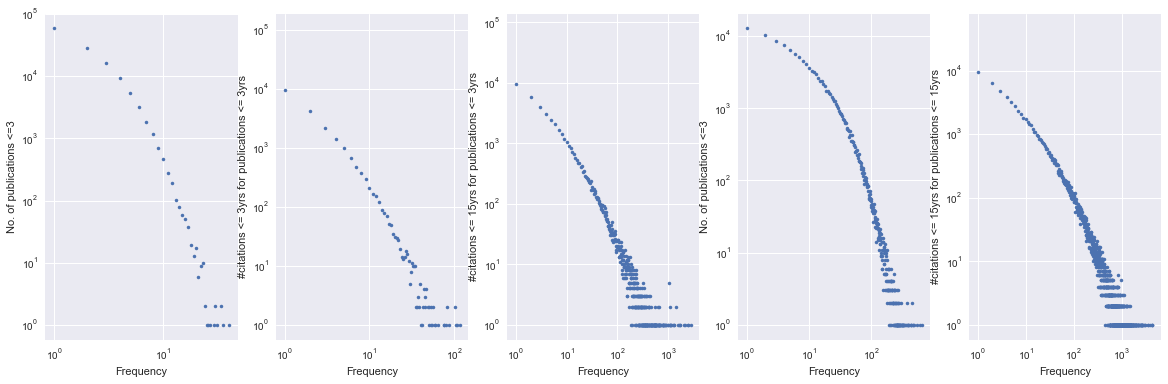

            npub_yr3  ncit_yr3_pub_yr3  ncit_yr15_pub_yr3      npub_yr15  \
count  126157.000000     126157.000000      126157.000000  126157.000000   
mean        2.316962          0.559390           6.701745      16.942318   
std         1.950497          2.338683          35.169849      23.263105   
min         1.000000          0.000000           0.000000       1.000000   
25%         1.000000          0.000000           0.000000       3.000000   
50%         2.000000          0.000000           0.000000       9.000000   
75%         3.000000          0.000000           3.000000      21.000000   
max        40.000000        117.000000        2775.000000     634.000000   

       ncit_yr15_pub_yr15  
count       126157.000000  
mean            31.099511  
std            102.568735  
min              0.000000  
25%              0.000000  
50%              3.000000  
75%             20.000000  
max           4297.000000  


In [82]:
fig, axes = plt.subplots(1,5,figsize=(20,6))
axes[0].plot(credibleAuthors['npub_yr3'].value_counts(),'.')
axes[0].set_xlabel('Frequency')
axes[0].set_xscale('log')
axes[0].set_ylabel('No. of publications <=3')
axes[0].set_yscale('log')

axes[1].plot(credibleAuthors['ncit_yr3_pub_yr3'].value_counts(),'.')
axes[1].set_xlabel('Frequency')
axes[1].set_xscale('log')
axes[1].set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes[1].set_yscale('log')

axes[2].plot(credibleAuthors['ncit_yr15_pub_yr3'].value_counts(),'.')
axes[2].set_xlabel('Frequency')
axes[2].set_xscale('log')
axes[2].set_ylabel('#citations <= 15yrs for publications <= 3yrs')
axes[2].set_yscale('log')

axes[3].plot(credibleAuthors['npub_yr15'].value_counts(),'.')
axes[3].set_xlabel('Frequency')
axes[3].set_xscale('log')
axes[3].set_ylabel('No. of publications <=3')
axes[3].set_yscale('log')

axes[4].plot(credibleAuthors['ncit_yr15_pub_yr15'].value_counts(),'.')
axes[4].set_xlabel('Frequency')
axes[4].set_xscale('log')
axes[4].set_ylabel('#citations <= 15yrs for publications <= 15yrs')
axes[4].set_yscale('log')

plt.show()

print(credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3','ncit_yr15_pub_yr3','npub_yr15','ncit_yr15_pub_yr15']].describe())
# print(credibleAuthors['ncit_yr3_pub_yr3'].describe())
# print(credibleAuthors['ncit_yr15_pub_yr3'].describe())
# print(credibleAuthors['npub_yr15'].describe())
# print(credibleAuthors['ncit_yr15_pub_yr15'].describe())

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


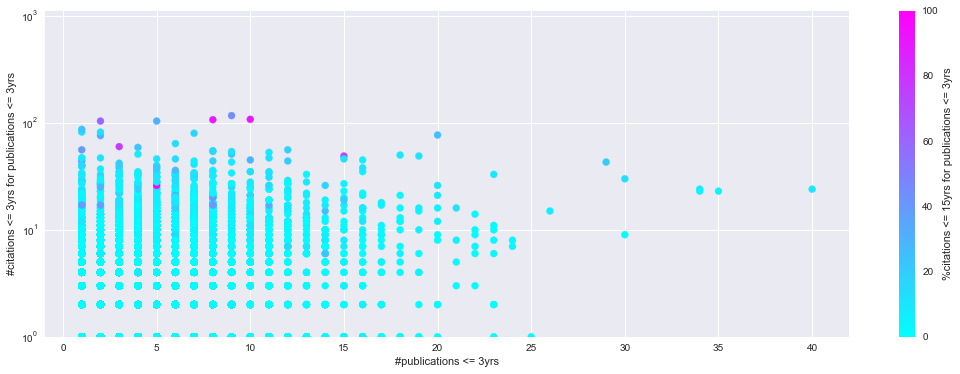

In [87]:
# Normalize(0 to 100) the citation obtained within 15 years for publication within 3 yrs
credibleAuthors['norm_ncit_yr15_pub_yr3'] = 100 * ((credibleAuthors['ncit_yr15_pub_yr3'] - credibleAuthors['ncit_yr15_pub_yr3'].min()) /
                                            (credibleAuthors['ncit_yr15_pub_yr3'].max() - credibleAuthors['ncit_yr15_pub_yr3'].min()))

fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr3'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 3yrs')

plt.show()
fig.savefig('fig/cit3_15yr-for-pub3yr.png')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


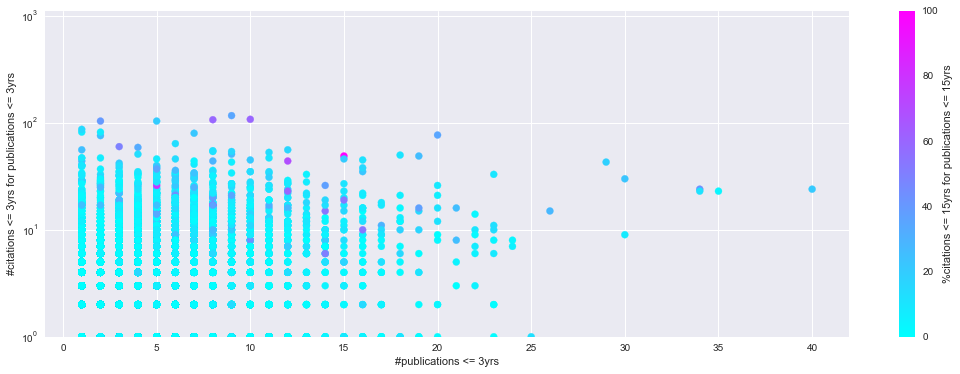

In [86]:
credibleAuthors['norm_ncit_yr15_pub_yr15'] = 100 * ((credibleAuthors['ncit_yr15_pub_yr15'] - credibleAuthors['ncit_yr15_pub_yr15'].min()) /
                                            (credibleAuthors['ncit_yr15_pub_yr15'].max() - credibleAuthors['ncit_yr15_pub_yr15'].min()))

fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr15'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 15yrs')

plt.show()
fig.savefig('fig/cit3_15yr-for-pub3_15yr.png')